# English Deep Writer

In this notebook I have built a deep neural network that can successfully identify writers based on their writing style. The data used to build the model was collected from IAM Handwriting database. This model is built on handwriting from 50 different writers. Each writer has written multiple paragraphs and sentences have been extracted from those paragraphs. 

## Model
I have built a multi layer CNN in Keras to classify writers. The inspiration for this work comes from a paper written by Linjie Xing, Yu Qiao referenced below. They were able to successfully classify English and Chinese test. I have taken some key concepts from their paper and modified the neural network tfor this task

## Results
Model's performance has been calculated based on a test set which has writings from among 50 writers. The model was not exposed to this data during training and validation
Classification accuracy on Test Set : ***94.1%***

## Resources
* [IAM handwriting database](http://www.fki.inf.unibe.ch/databases/iam-handwriting-database)
* [Deep Writer Paper] (https://arxiv.org/abs/1606.06472)

In [5]:
from __future__ import division
import numpy as np
import os
import glob

from random import *
from PIL import Image
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, RMSprop

Using TensorFlow backend.


In [6]:
# Create sentence writer mapping
#Dictionary with form and writer mapping
d = {}
with open('forms_for_parsing.txt') as f:
    for line in f:
        
        key = line.split(' ')[0]
       # print(key)
        writer = line.split(' ')[1]
        #print(writer)
        d[key] = writer
        print(d[key])
     

FileNotFoundError: ignored

In [0]:

# Create array of file names and corresponding target writer names
tmp = []
target_list = []
path_to_files = os.path.join('data_subset', '*')
for filename in sorted(glob.glob(path_to_files)):
    #print(filename)
    tmp.append(filename)
    image_name = filename.split('/')[-1]
    #print(image_name)
    file, ext = os.path.splitext(image_name)
    #print(file,ext)
   # print(file)
    parts = file.split('-')
    
    #print(parts)
    form = parts[0] + '-' + parts[1]
    #print(form)
    i=0
    for key in d:
        if key == form:
           # print(d[form])
            target_list.append(str(d[form]))
           # print(target_list[i])
            i=i+1
#print(target_list[1])            
img_files = np.asarray(tmp)

img_targets = np.asarray(target_list)
#print(img_targets[1])



## Visualizing dataset

See below data from Writer 1 - Each image is a unique sentence. 

<img src="markdown_pics/w1_s0.png"
     style="float: left; margin-right: 10px;" width = 800 />

    
<img src="markdown_pics/w1_s2.png"
     style="float: left; margin-right: 10px;" width = 800 />

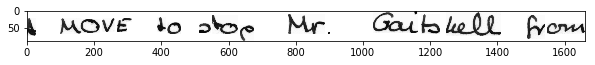

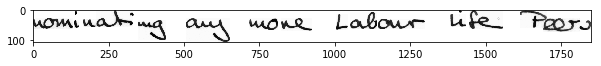

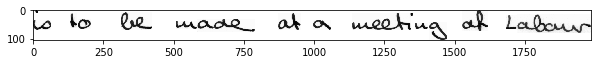

In [0]:
# Visualizing the data
for filename in img_files[:3]:
                          
    img = mpimg.imread(filename)
    plt.figure(figsize=(10,10))
    plt.imshow(img,cmap="gray")
    plt.show()

In [0]:
# Label Encode writer names for one hot encoding later
encoder = LabelEncoder()
encoder.fit(img_targets)
#print(img_targets[9])
encoded_Y = encoder.transform(img_targets)
#print(encoded_Y)

print(img_files[:3], img_targets[:3], encoded_Y[:3])

['data_subset/a01-000u-s00-00.png' 'data_subset/a01-000u-s00-01.png'
 'data_subset/a01-000u-s00-02.png'] ['000' '000' '000'] [0 0 0]


In [0]:
#split into test train and validation in ratio 4:1:1

from sklearn.model_selection import train_test_split
train_files, rem_files, train_targets, rem_targets = train_test_split(
        img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True)

validation_files, test_files, validation_targets, test_targets = train_test_split(
        rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)
print(len(train_files))


(3233,) (833,) (833,)
(3233,) (833,) (833,)
3233


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Input to the model  

As suggested in the paper, the input to the model are not unique sentences but rather random patches cropped from each sentence. This was done by:

* Resizing each sentence so that  new height is 113 pixels and new width is such that original aspect ratio is maintained
* As stated in the paper, distorting the shape of image by changing the aspect ratio resulted in a big drop in model performance
* From the adjusted image, patches of 113x113 are randomly cropped

Pic below shows the random 113x113 patches from one of the sentences combined in one frame

Collage of 8 113x113 patches: 
<img src='markdown_pics/combined.jpeg' width=200>


In [4]:
# Generator function for generating random crops from each sentence

# # Now create generators for randomly cropping 113x113 patches from these images

batch_size = 8
num_classes = 50

# Start with train generator shared in the class and add image augmentations
def generate_data(samples, target_files,  batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]
           # print(batch_samples)  
            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)
                cur_width = im.size[0]
                cur_height = im.size[1]

                 print('middle')
                height_fac = 113 / cur_height

                new_width = int(cur_width * height_fac)
                size = new_width, 113

                imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
                now_width = imresize.size[0]
                now_height = imresize.size[1]
                # Generate crops of size 113x113 from this resized image and keep random 10% of crops

                avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

                # Pick random x%
                pick_num = int(len(avail_x_points)*factor)

                # Now pick
                random_startx = sample(avail_x_points,  pick_num)

                for start in random_startx:
                    imcrop = imresize.crop((start, 0, start+113, 113))
                    images.append(np.asarray(imcrop))
                    targets.append(batch_target)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(targets)

            #reshape X_train for feeding in later
            X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
            #convert to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255

            #One hot encode y
            y_train = to_categorical(y_train, num_classes)

            yield shuffle(X_train, y_train)

IndentationError: ignored

In [0]:
q# Generate data for training and validation
train_generator = generate_data(train_files, train_targets, batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_targets, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor = 0.1)

In [0]:
# Build a neural network in Keras

# Function to resize image to 56x56
def resize_image(image):
    import tensorflow as tf
    return tf.image.resize_images(image,[56,56])

# Function to resize image to 64x64
row, col, ch = 113, 113, 1

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))

# Resise data within the neural network
model.add(Lambda(resize_image))  #resize images to allow for easy computation

# CNN model - Building the model suggested in paper

model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

model.add(Convolution2D(filters= 128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, name='dense1'))  #1024
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, name='dense2'))  #1024
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))  #softmax since output is within 50 classes

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 115, 115, 1)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 56, 56, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
activation_6 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_7 (Activation)    (None, 14, 14, 64)        0         
__________

In [0]:
 #this portion-ebey

nb_epoch = 2

samples_per_epoch = 3268
nb_samples = 842


#save every model using Keras checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
filepath="checkpoint2/check-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

# Model fit generator
#history_object = model.fit_generator(generator=train_generator, steps_per_epoch= samples_per_epoch,
                                     # validation_data=validation_generator,
                                      #validation_steps=nb_samples, epochs=nb_epoch, verbose=1, callbacks=callbacks_list)
history_objec=model.fit_generator(train_generator,steps_per_epoch=3268,epochs=1,verbose=1,callbacks=callbacks_list,validation_data=validation_generator,validation_steps=842)


ValueError: ignored

## Test model performance on the Test Set

1. Accuracy on test set
2. Samples predicted to be from the same writer

In [0]:
# Load save model and use for prediction on test set
model.load_weights('low_loss.hdf5')
scores = model.evaluate_generator(test_generator,842) 
print("Accuracy = ", scores[1])

OSError: Unable to open file (unable to open file: name = 'low_loss.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [0]:
# Play with results from model 
predictions = model.predict(X_test, verbose =1)

print(predictions.shape)
predicted_writer = []
for pred in predictions:
    predicted_writer.append(np.argmax(pred))
print(len(predicted_writer))

NameError: name 'X_test' is not defined

In [0]:
writer_number = 18
total_images =10
counter = 0
for i in range(len(predicted_writer)//10):
    if predicted_writer[i] == writer_number:
        image = X_test[i].squeeze()
        plt.figure(figsize=(2,2))
        plt.imshow(image, cmap ='gray')

NameError: name 'predicted_writer' is not defined

## Next Steps
* Fine tune model hyper parameters to further improve accuracy on English dataset
* Replicate the process on Khatt dataset of handwritten Arabic Samples

FileNotDownloadableError: ignored

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!rm -rf data_subset